# Simulation results
## Full run for scenario 4 - Parametric demand for historical transactions

#### Maria Silva, May 2025

## 1. Imports and settings

Let's start by importing the necessary libraries and setting up some directories and files.


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [2]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)
meanprops_small = {
    "markerfacecolor": "white",
    "markeredgecolor": "grey",
    "markersize": "6",
}
meanprops_big = {
    "markerfacecolor": "white",
    "markeredgecolor": "grey",
    "markersize": "8",
}

In [3]:
# Main directories and files
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
data_dir = os.path.join(repo_dir, "data")
sim_dir = os.path.join(data_dir, "sim")

In [4]:
meter_names_map = {
    'one_dim_scheme': 'One-dimensional', 
    'compute_vs_others': 'Compute vs. Others', 
    'state_vs_others': 'State vs. Others',
    'access_vs_others': 'Access vs. Others', 
    'bandwidth_vs_others': 'Bandwidth vs. Others',
    'state_vs_compute_vs_others': 'State vs. Compute vs. Others',
    'state_vs_compute_vs_access_vs_others': 'State vs. Compute vs. Access vs. Others'
}
meter_names_map_v2 = {
    'one_dim_scheme': 'One-dimensional', 
    'compute_vs_others': 'Compute vs. Others', 
    'state_vs_others': 'State vs. Others',
    'access_vs_others': 'Access vs. Others', 
    'bandwidth_vs_others': 'Bandwidth vs. Others',
    'state_vs_compute_vs_others': 'State vs. Compute vs. Others',
    'state_vs_compute_vs_access_vs_others': 'State vs. Compute vs. \n Access vs. Others'
}

## 2. Load simulation results

Now, we need to read the csv files that contain the results from the simulation results.

In [5]:
file_names = [
    f"historical_txs_sim_results_demand=parametric_mul={i}.csv" for i in [1, 2, 3, 5]
]
raw_df = pd.DataFrame()
for file_name in file_names:
    temp_df = pd.read_csv(os.path.join(sim_dir, file_name))
    raw_df = pd.concat([raw_df, temp_df], ignore_index=True)
raw_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600000 entries, 0 to 5599999
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   iter                 5600000 non-null  int64  
 1   block                5600000 non-null  int64  
 2   utilization          5600000 non-null  float64
 3   gas_used             5600000 non-null  float64
 4   one_dim_utilization  5600000 non-null  float64
 5   throughput           5600000 non-null  int64  
 6   mempool_size         5600000 non-null  int64  
 7   demand_type          5600000 non-null  object 
 8   demand_mul           5600000 non-null  int64  
 9   meter_scheme         5600000 non-null  object 
 10  limit                5600000 non-null  float64
dtypes: float64(4), int64(5), object(2)
memory usage: 470.0+ MB


In [6]:
raw_df.groupby("demand_mul")[["iter", "block"]].max()

,iter,block
demand_mul,,
1,9999,9
2,9999,9
3,9999,9
5,9999,9


In [7]:
df = raw_df.copy()

df["gas_used_million"] = df["gas_used"]/1e6
df["Limit"] =np.where(df["limit"]==36000000, "36M", "18M")
df["meter_scheme_v2"] = df["meter_scheme"].map(meter_names_map_v2)
df["meter_scheme"] = df["meter_scheme"].map(meter_names_map)
df["is_mempool_empty"] = df["mempool_size"]==0
df["Demand multiplier"] = df["demand_mul"].astype("str")+"x"

df = df.drop(columns=["demand_type", "demand_mul"])

df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600000 entries, 0 to 5599999
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   iter                 5600000 non-null  int64  
 1   block                5600000 non-null  int64  
 2   utilization          5600000 non-null  float64
 3   gas_used             5600000 non-null  float64
 4   one_dim_utilization  5600000 non-null  float64
 5   throughput           5600000 non-null  int64  
 6   mempool_size         5600000 non-null  int64  
 7   meter_scheme         5600000 non-null  object 
 8   limit                5600000 non-null  float64
 9   gas_used_million     5600000 non-null  float64
 10  Limit                5600000 non-null  object 
 11  meter_scheme_v2      5600000 non-null  object 
 12  is_mempool_empty     5600000 non-null  bool   
 13  Demand multiplier    5600000 non-null  object 
dtypes: bool(1), float64(5), int64(4), object(4)
memory

In [8]:
df_36 = df[df["Limit"]=="36M"]
df_18 = df[df["Limit"]=="18M"]

In [9]:
scenario_title = "Scenario 4: Parametric demand for historical transactions"
meter_order = df["meter_scheme"].unique().tolist()
meter_order_v2 = df["meter_scheme_v2"].unique().tolist()

## 3. Transaction demand

                        mean         std  median
Demand multiplier                               
1x                 153.31964   46.400784   149.0
2x                 296.75349   58.375404   297.0
3x                 430.29498   97.497651   445.0
5x                 699.95186  203.727602   756.0


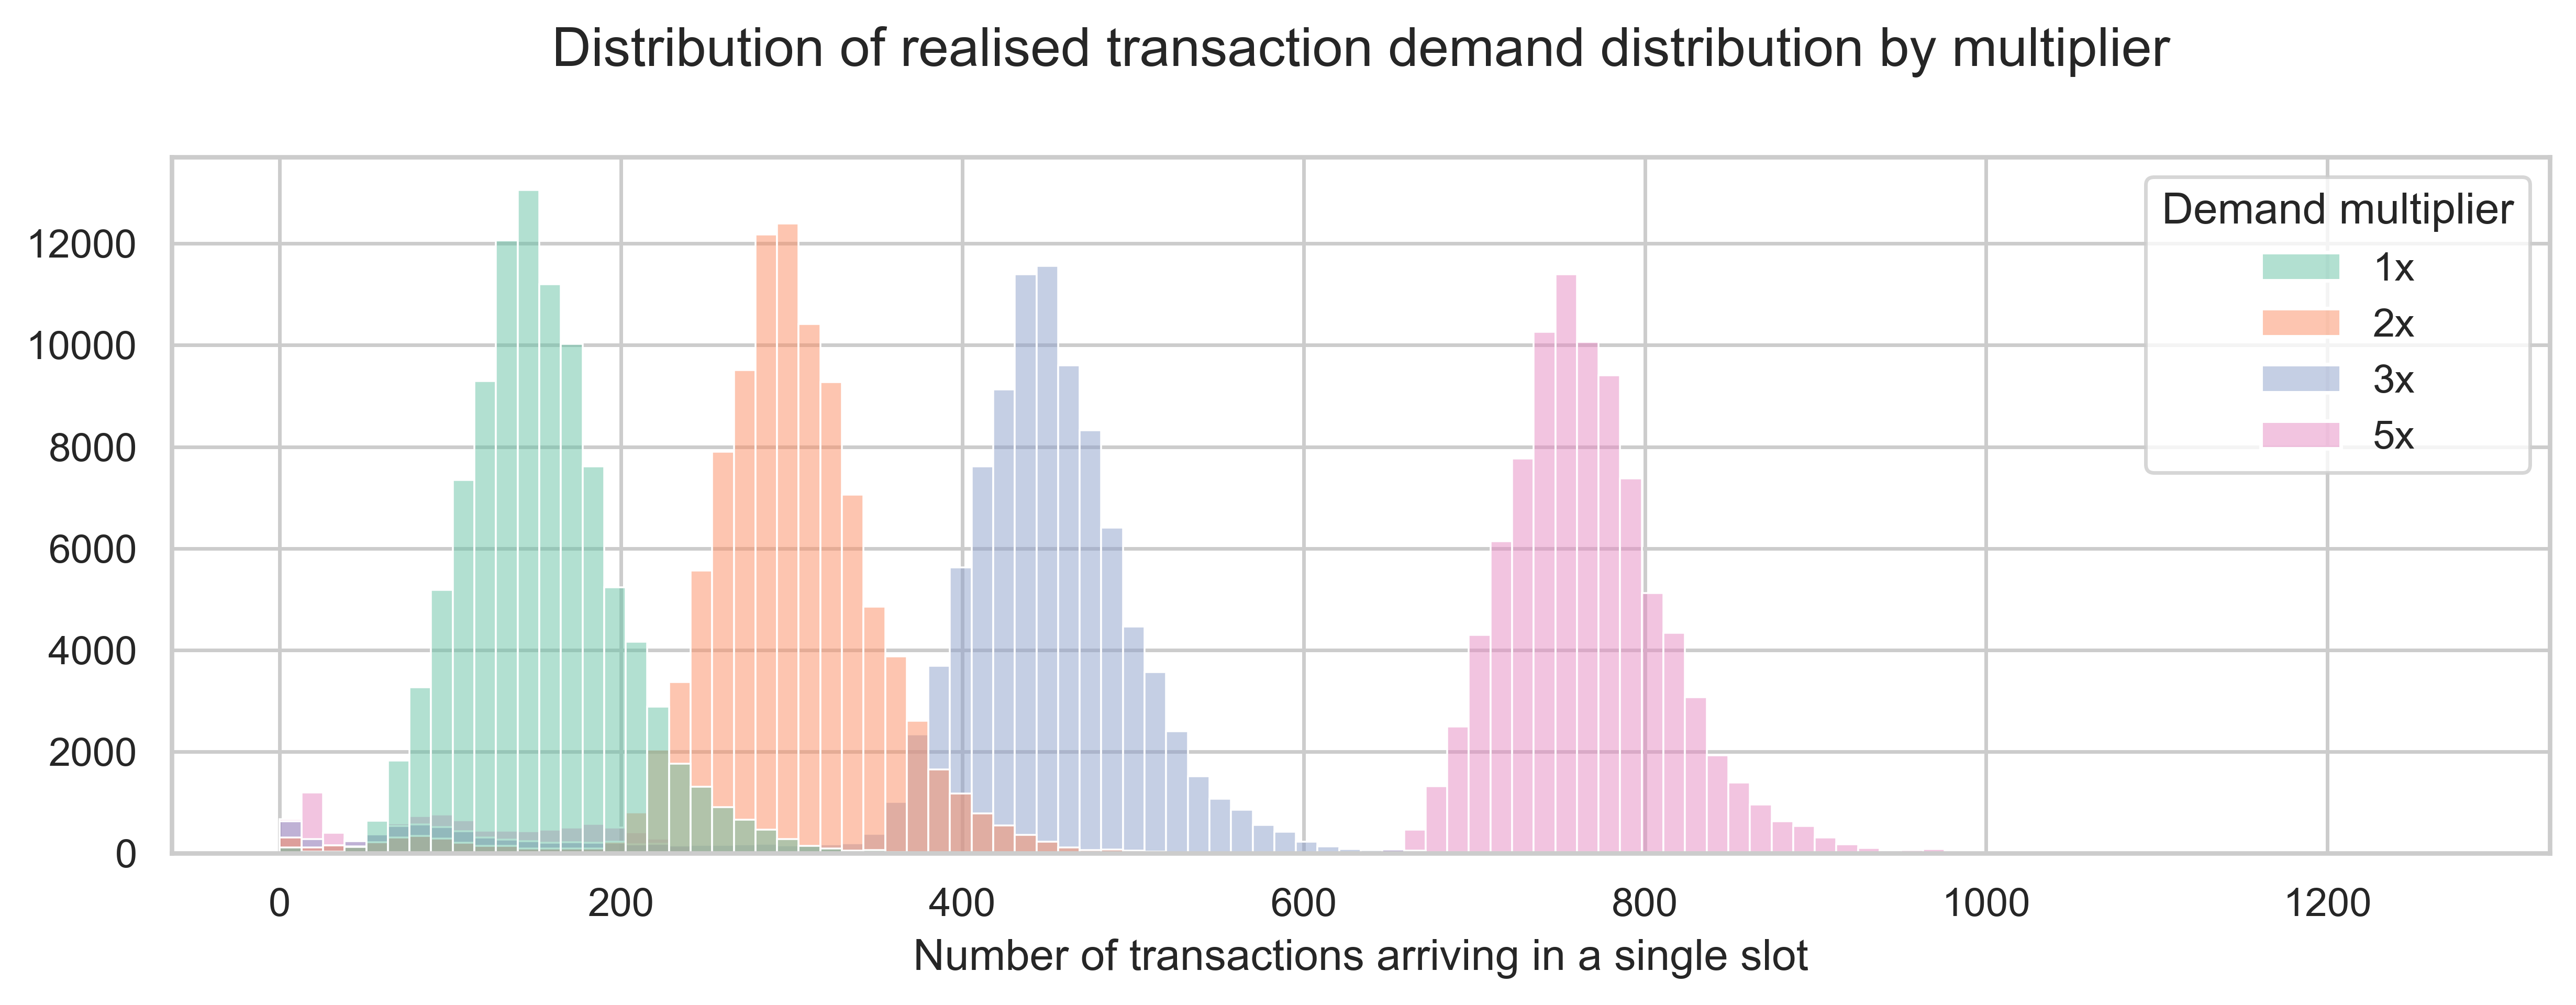

In [10]:
temp_df = df_36[df_36["meter_scheme"]=="One-dimensional"]
temp_df["mempool_diff"] = temp_df.groupby(["iter", "Demand multiplier"])[["mempool_size"]].diff().fillna(0)
temp_df["tx_demand"] = temp_df["mempool_diff"] + temp_df["throughput"]

print(temp_df.groupby(["Demand multiplier"])["tx_demand"].agg(["mean", "std", "median"]))

plt.figure(figsize=(10, 4))
ax = sns.histplot(temp_df, x="tx_demand", hue="Demand multiplier", bins=100)
plt.title(
    f"Distribution of realised transaction demand distribution by multiplier",
    pad=25,
)
plt.xlabel("Number of transactions arriving in a single slot")
plt.ylabel("")
plt.tight_layout()
plt.show()

## 4. Utilization

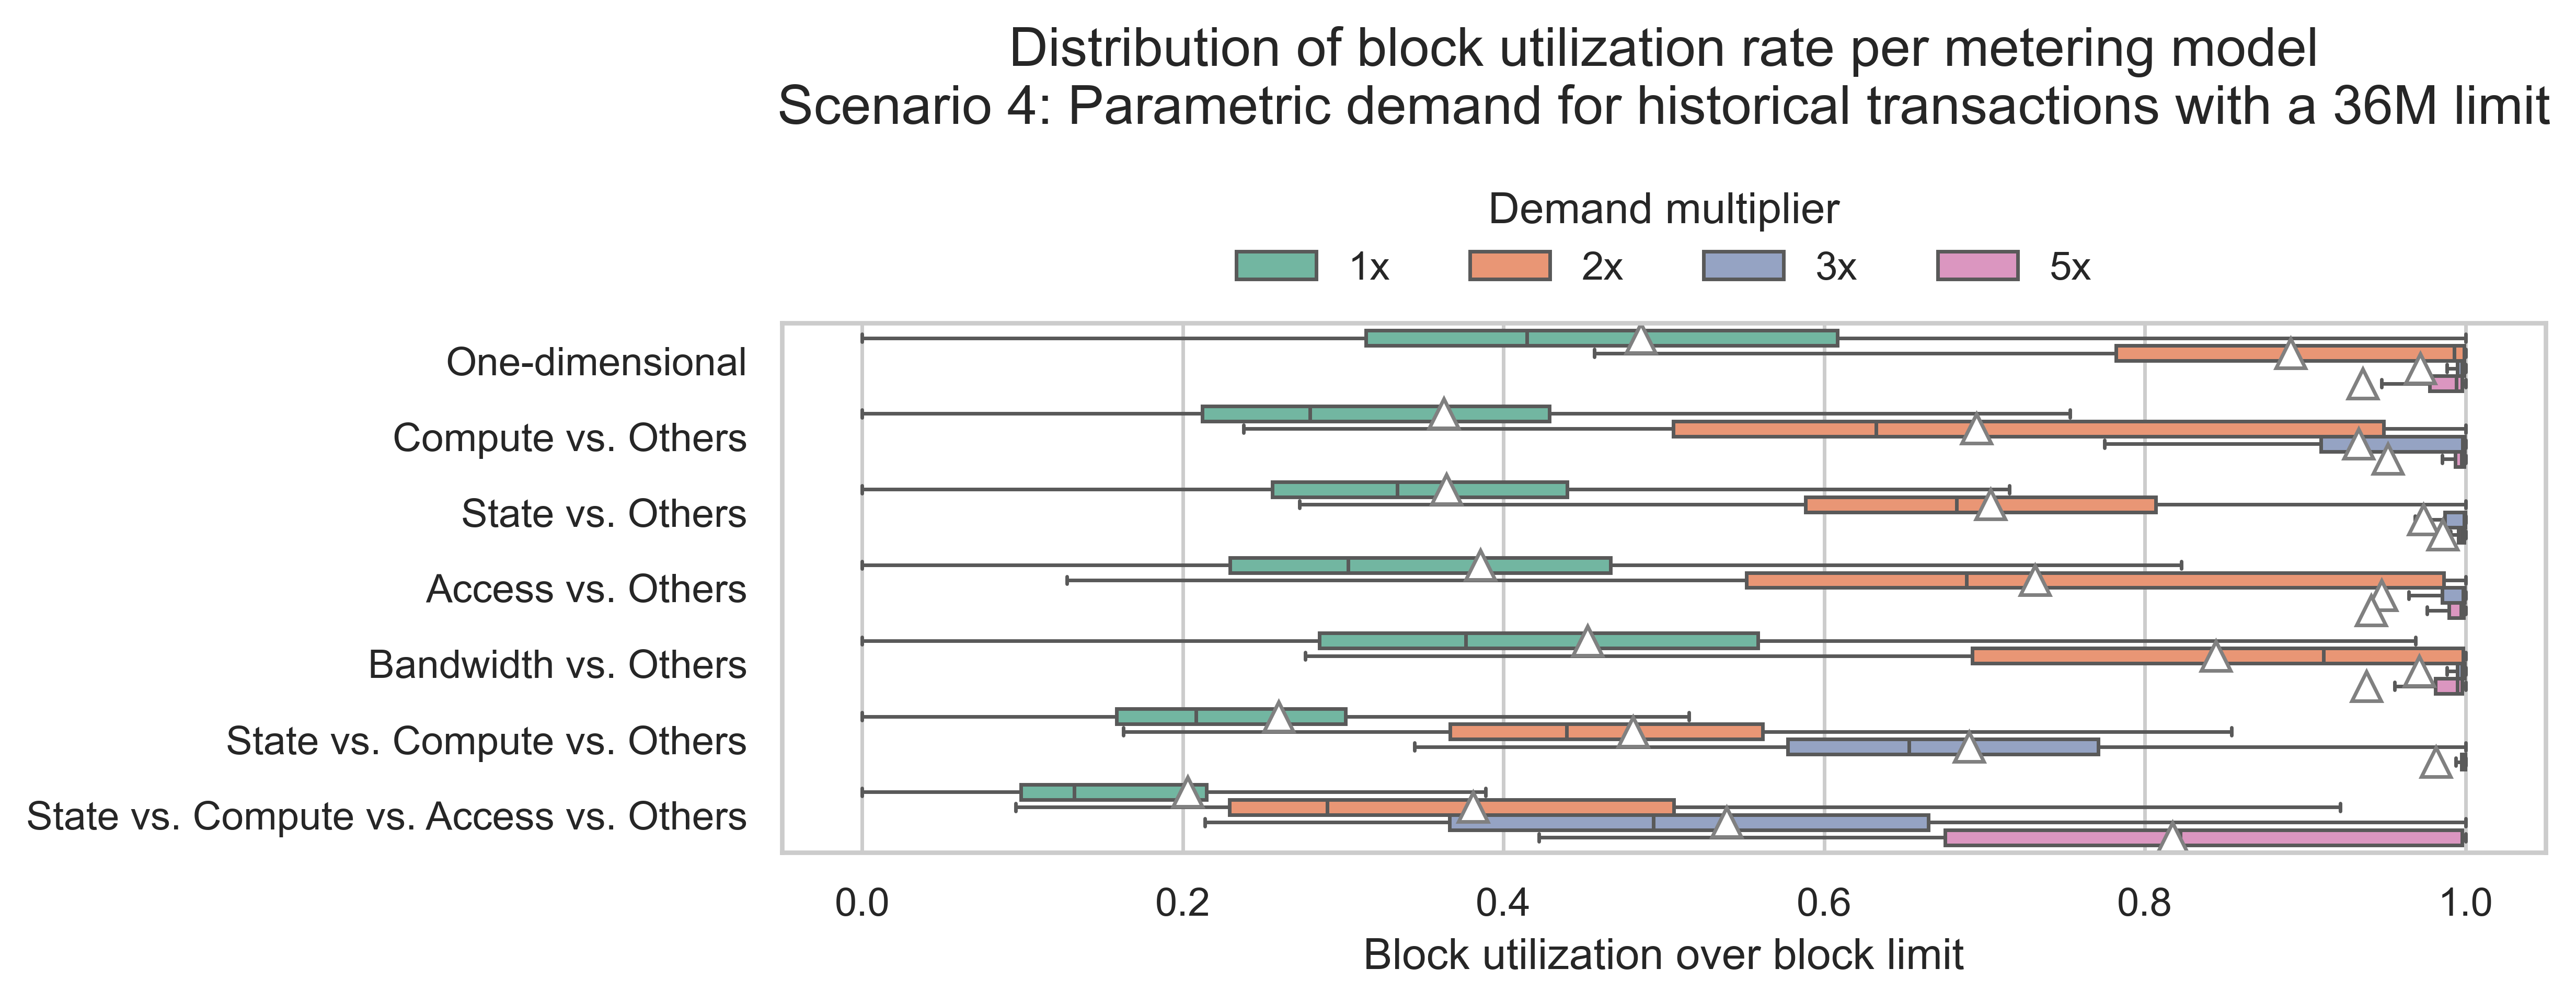

In [11]:
plt.figure(figsize=(10, 4))
ax = sns.boxplot(
    data=df_36,
    x="utilization",
    y="meter_scheme",
    hue="Demand multiplier",
    showmeans=True,
    meanprops=meanprops_big,
    showfliers=False,
    order=meter_order,
)
plt.xlabel("Block utilization over block limit")
plt.ylabel("")
plt.title(
    f"Distribution of block utilization rate per metering model\n{scenario_title} with a 36M limit",
    pad=55,
)

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, frameon=False,
)
plt.tight_layout()
plt.show()

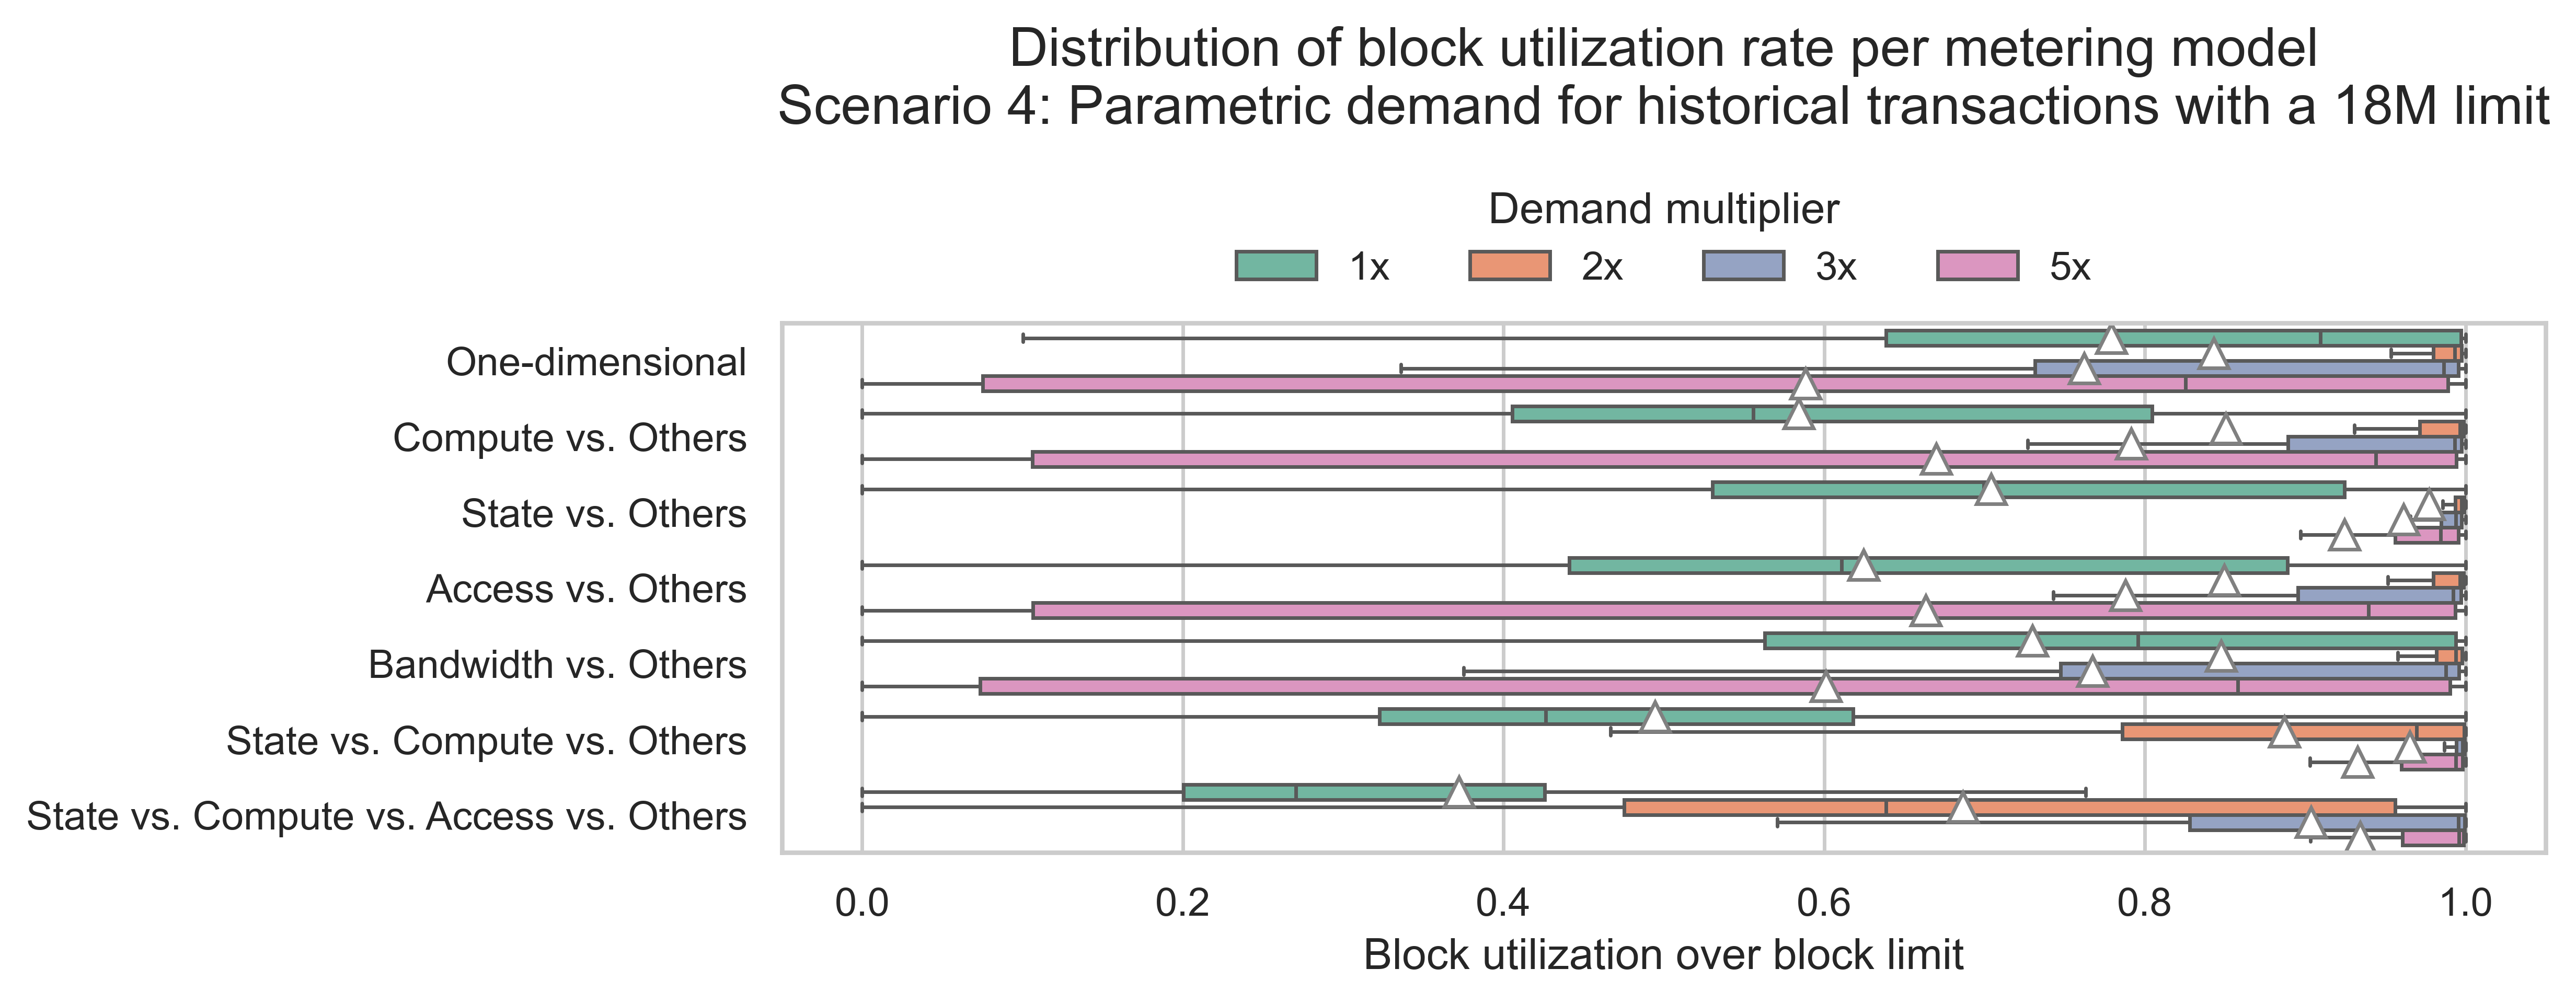

In [12]:
plt.figure(figsize=(10, 4))
ax = sns.boxplot(
    data=df_18,
    x="utilization",
    y="meter_scheme",
    hue="Demand multiplier",
    showmeans=True,
    meanprops=meanprops_big,
    showfliers=False,
    order=meter_order,
)
plt.xlabel("Block utilization over block limit")
plt.ylabel("")
plt.title(
    f"Distribution of block utilization rate per metering model\n{scenario_title} with a 18M limit",
    pad=55,
)

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, frameon=False,
)
plt.tight_layout()
plt.show()

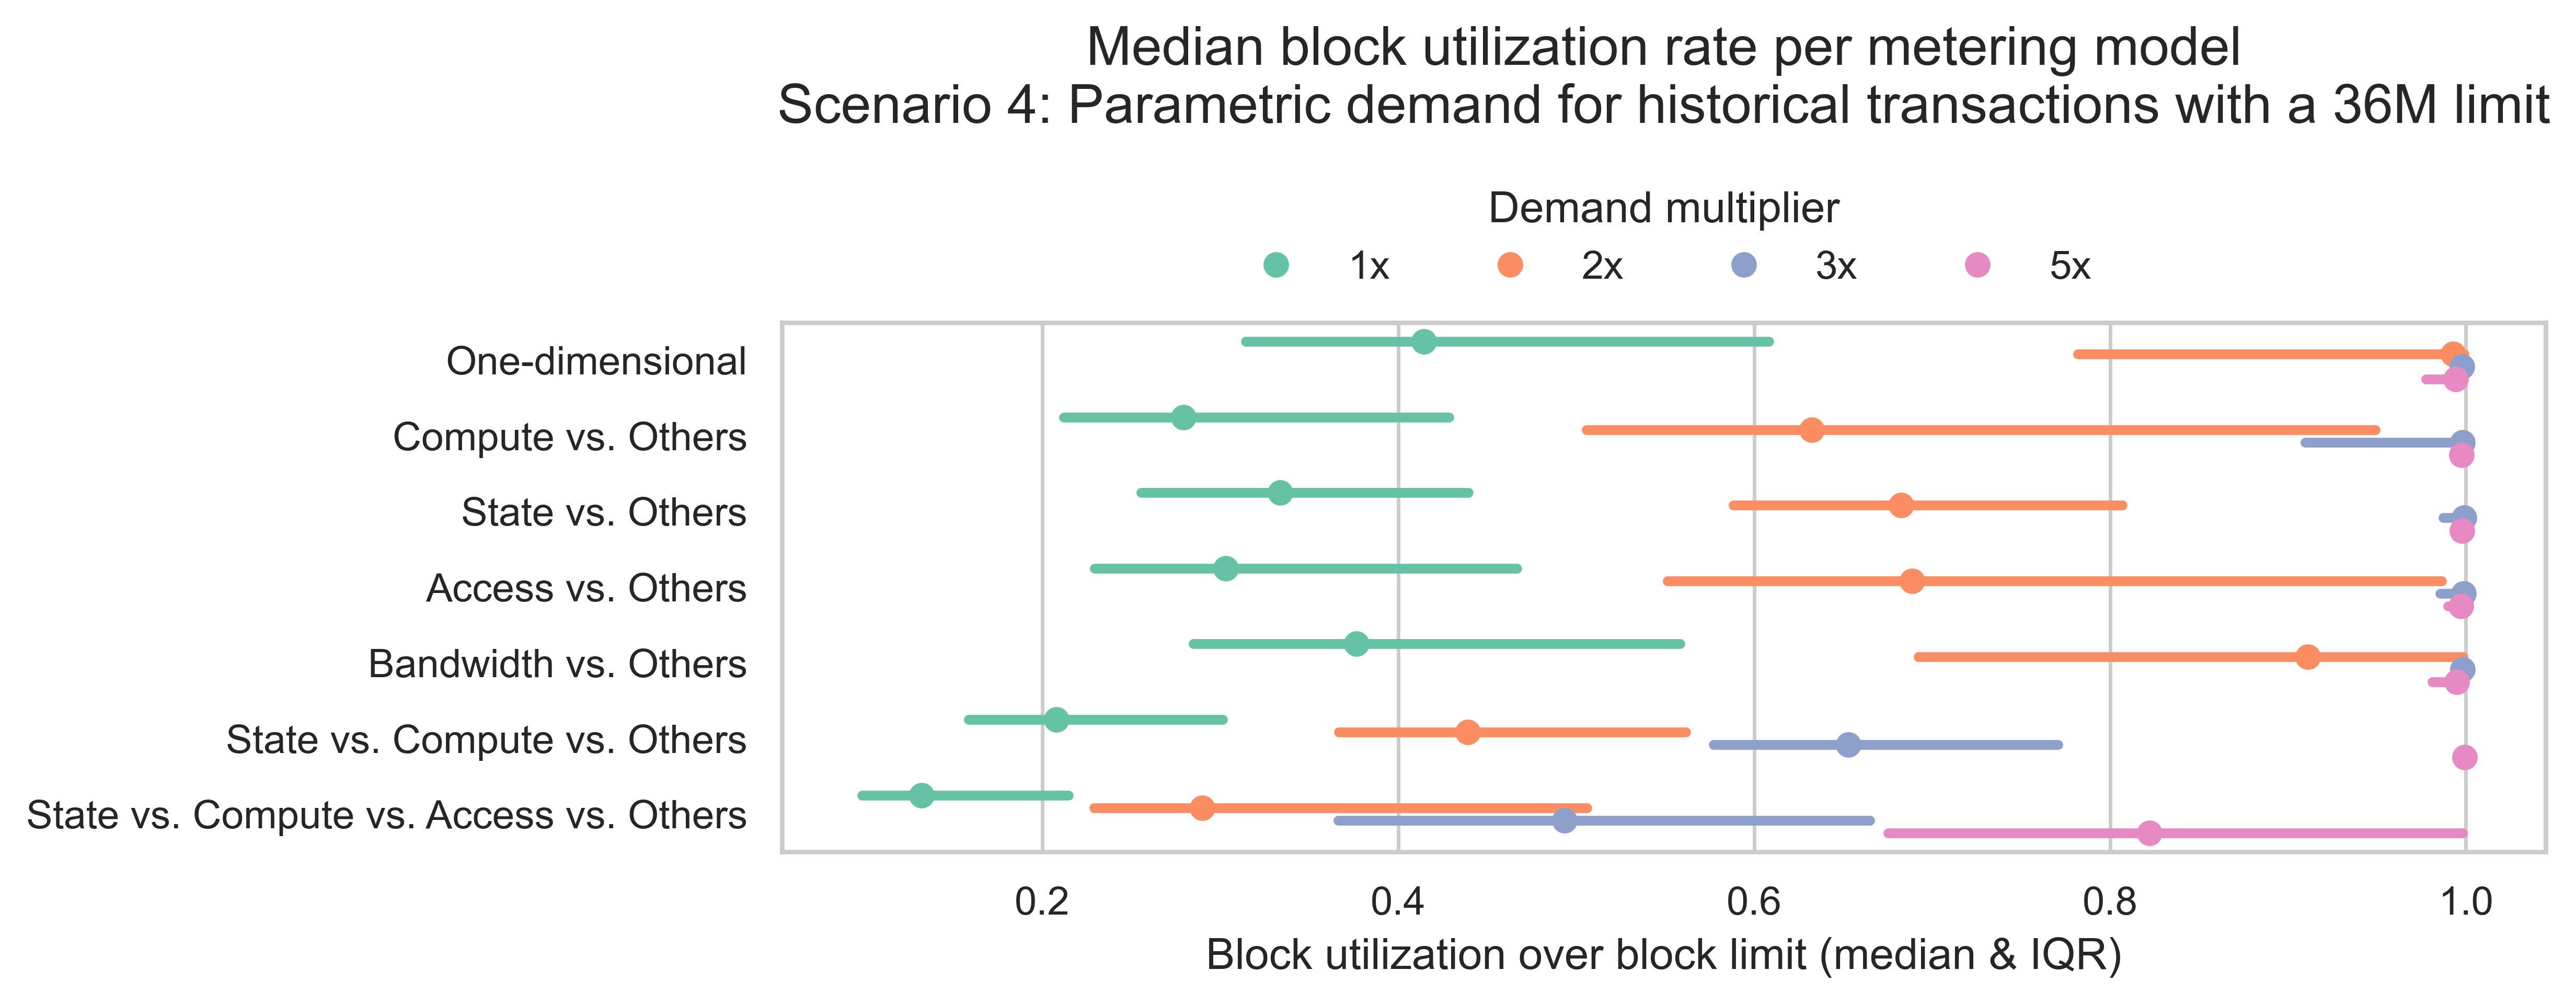

In [13]:
plt.figure(figsize=(10, 4))
ax = sns.pointplot(
    data=df_36,
    x="utilization",
    y="meter_scheme",
    hue="Demand multiplier",
    order=meter_order,
    linestyle="none",
    errorbar=("pi", 50),
    estimator="median",
    markersize=5,
    dodge=0.5
)
plt.xlabel("Block utilization over block limit (median & IQR)")
plt.ylabel("")
plt.title(
    f"Median block utilization rate per metering model\n{scenario_title} with a 36M limit",
    pad=55,
)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, frameon=False,
)
plt.tight_layout()
plt.show()

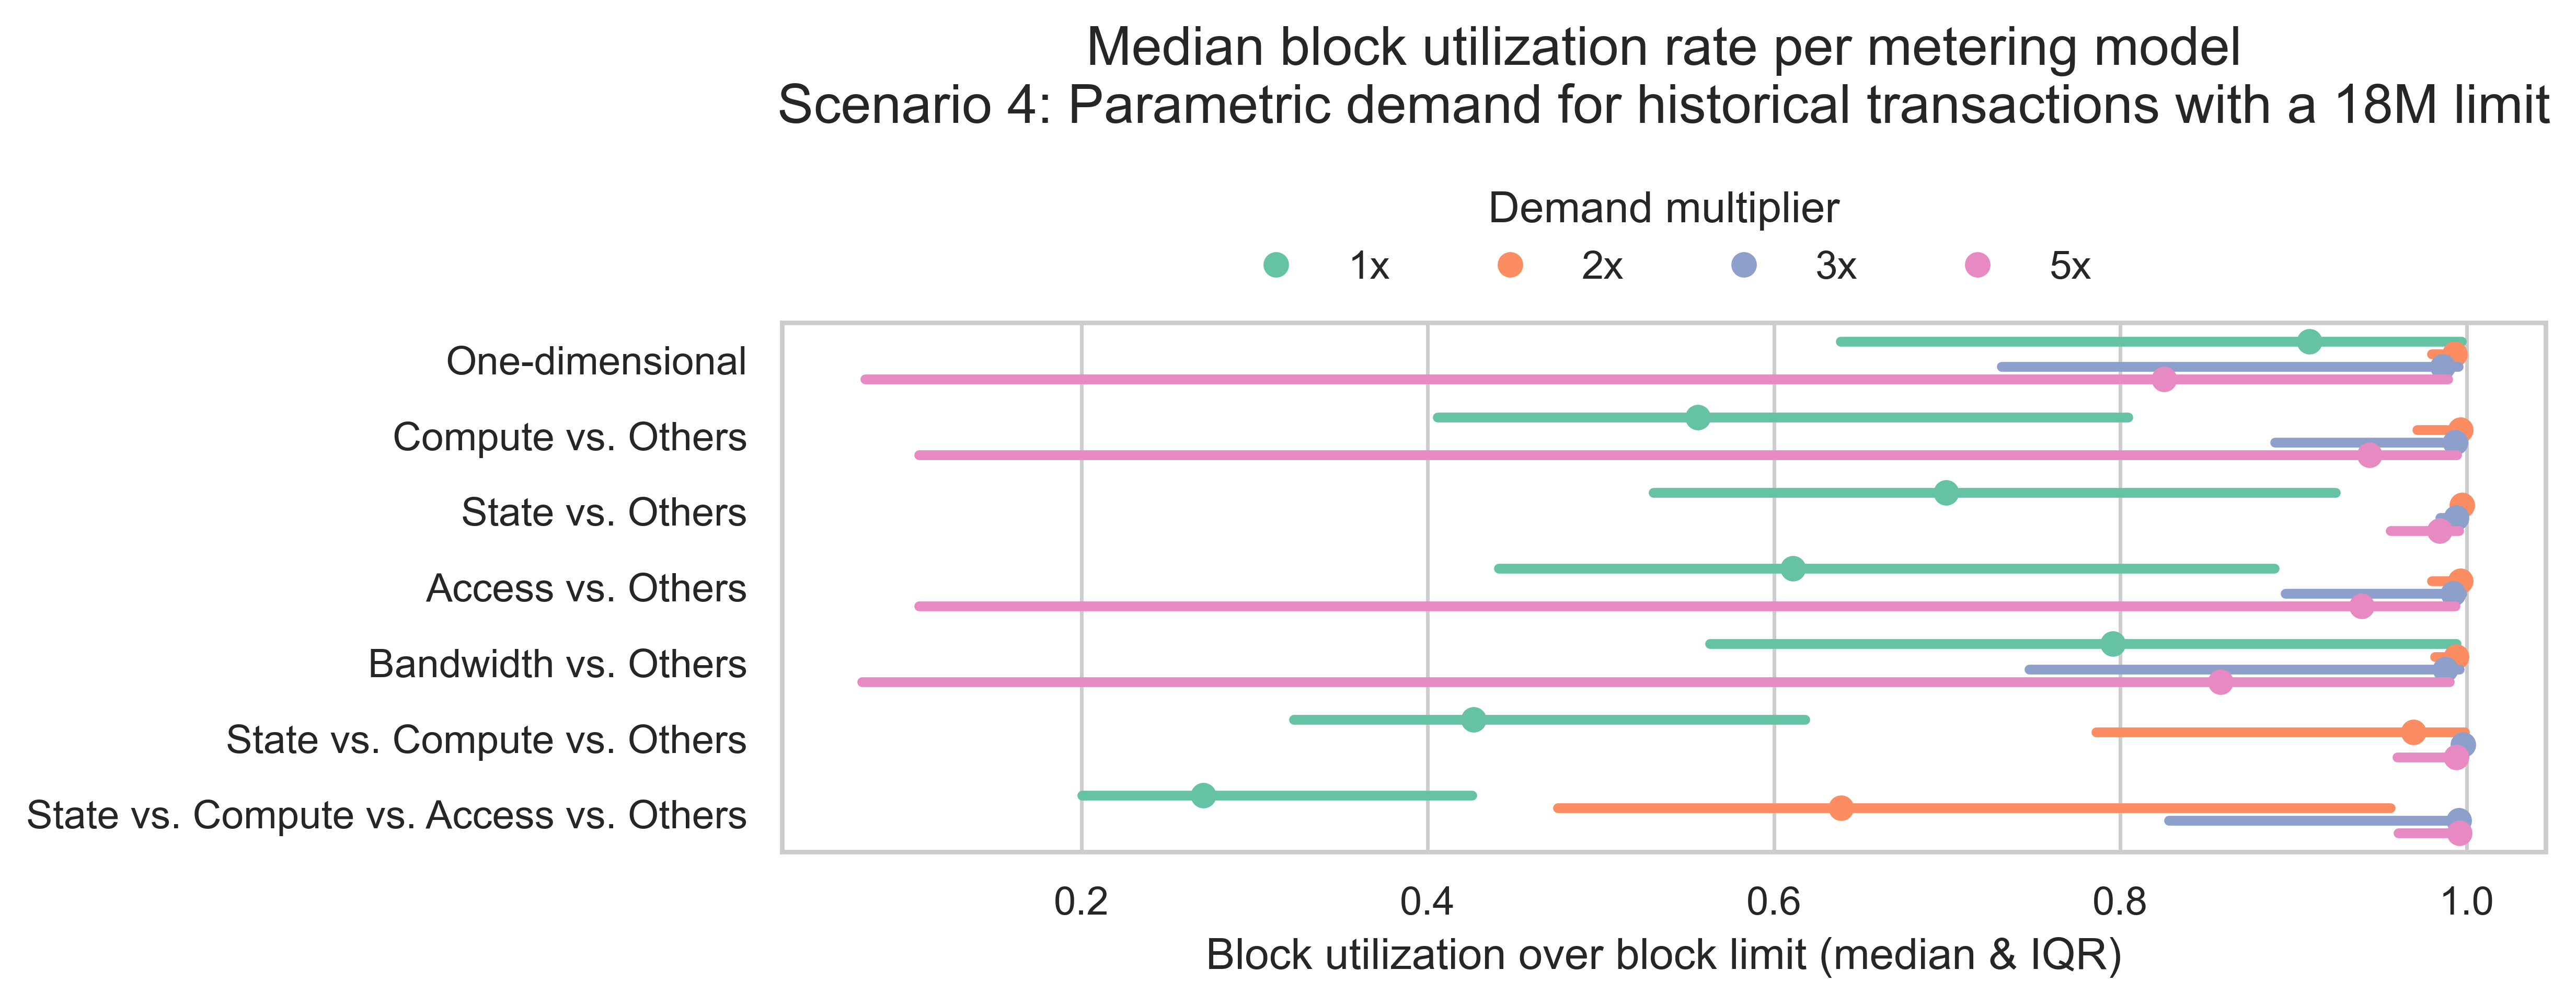

In [14]:
plt.figure(figsize=(10, 4))
ax = sns.pointplot(
    data=df_18,
    x="utilization",
    y="meter_scheme",
    hue="Demand multiplier",
    order=meter_order,
    linestyle="none",
    errorbar=("pi", 50),
    estimator="median",
    markersize=5,
    dodge=0.5
)
plt.xlabel("Block utilization over block limit (median & IQR)")
plt.ylabel("")
plt.title(
    f"Median block utilization rate per metering model\n{scenario_title} with a 18M limit",
    pad=55,
)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, frameon=False,
)
plt.tight_layout()
plt.show()

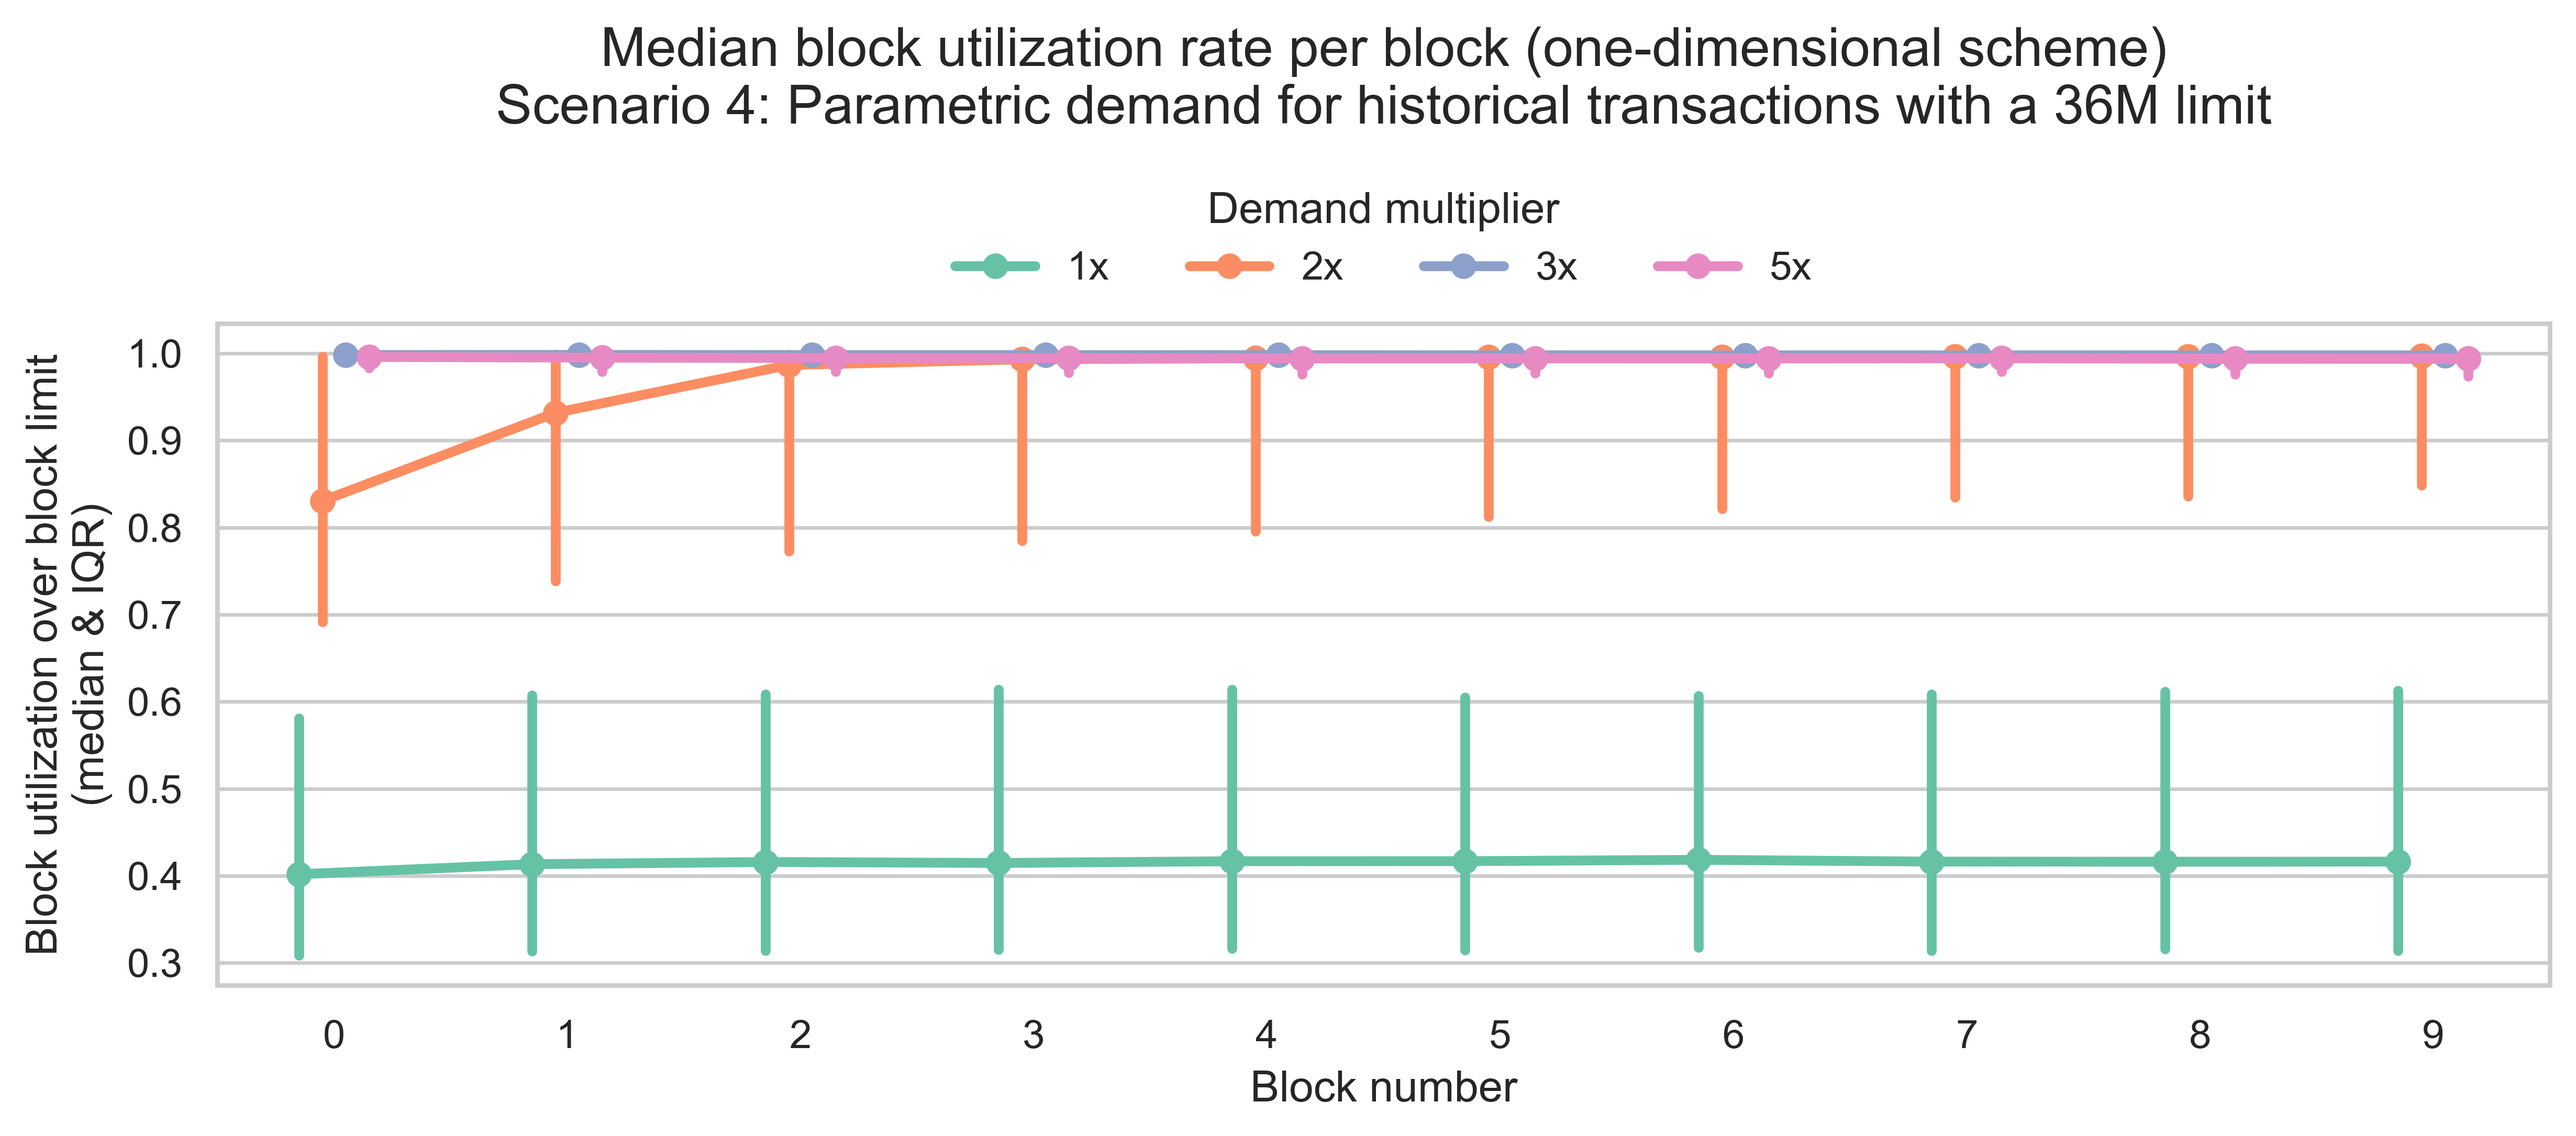

In [15]:
plt.figure(figsize=(10, 4.5))
ax = sns.pointplot(
    data=df_36[df_36["meter_scheme"]=="One-dimensional"],
    x="block",
    y="utilization",
    hue="Demand multiplier",
    errorbar=("pi", 50),
    estimator="median",
    markersize=5,
    dodge=0.3
)
plt.xlabel("Block number")
plt.ylabel("Block utilization over block limit\n(median & IQR)")
plt.title(
    f"Median block utilization rate per block (one-dimensional scheme)\n{scenario_title} with a 36M limit",
    pad=55,
)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, frameon=False,
)
plt.tight_layout()
plt.show()

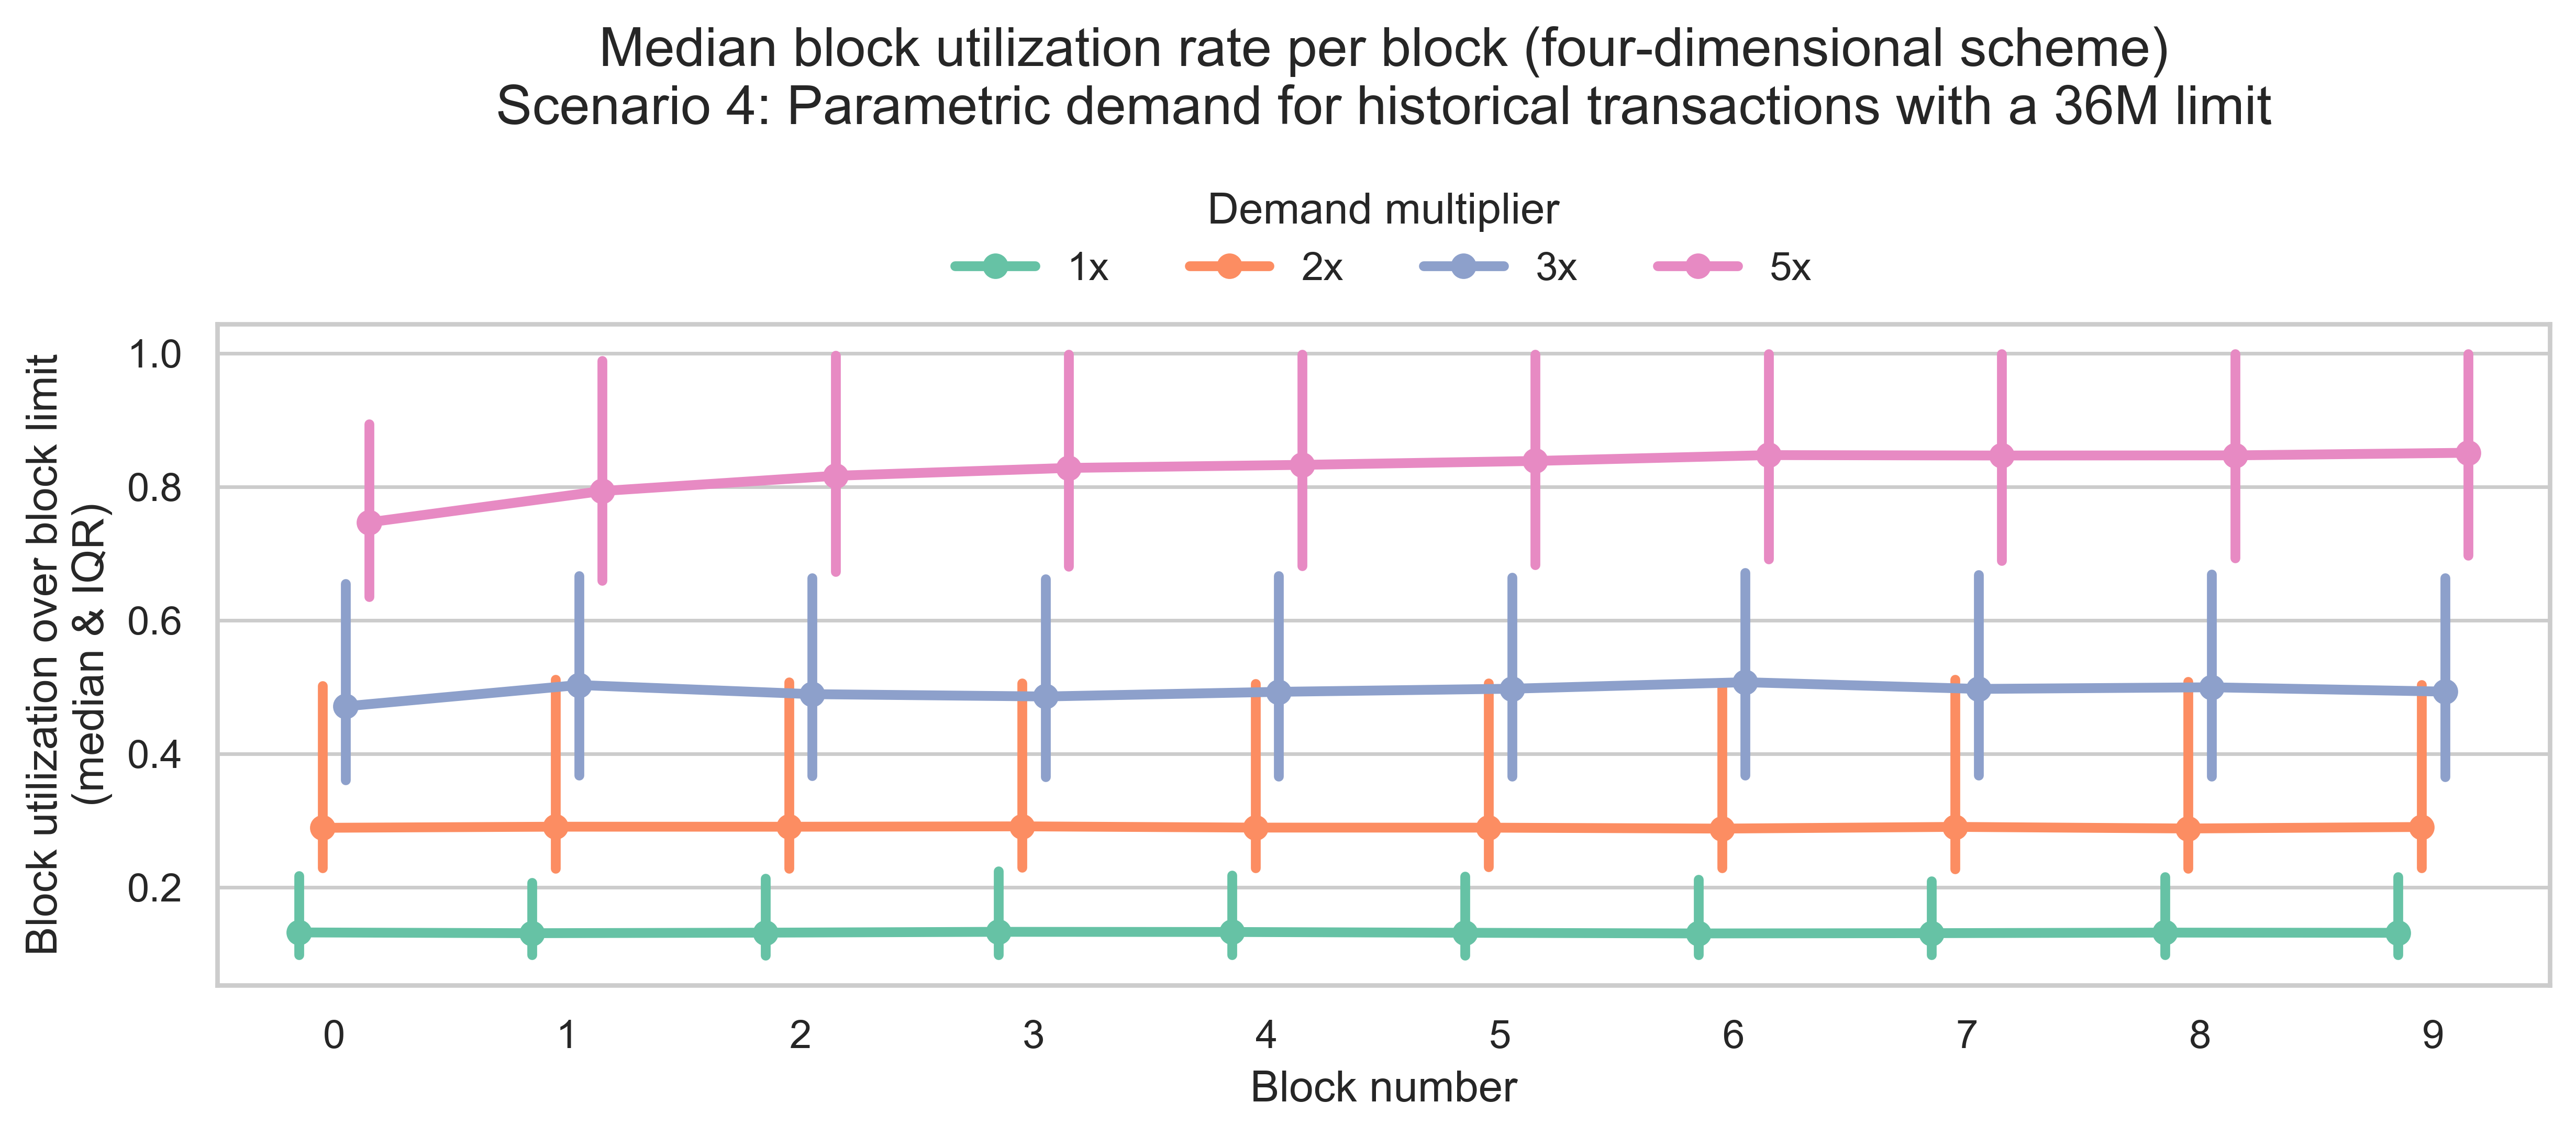

In [16]:
plt.figure(figsize=(10, 4.5))
ax = sns.pointplot(
    data=df_36[df_36["meter_scheme"]=="State vs. Compute vs. Access vs. Others"],
    x="block",
    y="utilization",
    hue="Demand multiplier",
    errorbar=("pi", 50),
    estimator="median",
    markersize=5,
    dodge=0.3
)
plt.xlabel("Block number")
plt.ylabel("Block utilization over block limit\n(median & IQR)")
plt.title(
    f"Median block utilization rate per block (four-dimensional scheme)\n{scenario_title} with a 36M limit",
    pad=55,
)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, frameon=False,
)
plt.tight_layout()
plt.show()

In [17]:
df.groupby(["meter_scheme", "Limit"])["gas_used_million"].agg(["mean", "std", "median"])

mean        std     median
meter_scheme                            Limit                                 
Access vs. Others                       18M    17.193509   8.931805  20.050155
                                        36M    34.725987  13.494004  39.440351
Bandwidth vs. Others                    18M    14.114673   7.124785  18.160888
                                        36M    30.592002   9.877776  36.607185
Compute vs. Others                      18M    18.126204   9.572184  20.717638
                                        36M    36.111434  14.528057  40.083645
One-dimensional                         18M    13.375453   6.742961  17.677520
                                        36M    29.558871   9.060949  35.698606
State vs. Compute vs. Access vs. Others 18M    32.749267  15.947444  29.202537
                                        36M    47.890030  29.018934  42.325026
State vs. Compute vs. Others            18M    28.679382  11.091381  30.040626
                                        36M    45.361311  24.402701  42.450737
State vs. Others                        18M    22.199034   6.844351  21.828328
                                        36M    38.778390  16.973213  42.268126

## 5. Mempool

In [31]:
temp_df = (
    df_36.groupby(["meter_scheme", "Demand multiplier"])["is_mempool_empty"]
    .mean()
    .round(4)
)
temp_df = temp_df.reset_index().pivot(
    index="meter_scheme", columns="Demand multiplier", values="is_mempool_empty"
).loc[meter_order]
temp_df.columns = temp_df.columns + " mult."
temp_df

Demand multiplier,1x mult.,2x mult.,3x mult.,5x mult.
meter_scheme,,,,
One-dimensional,0.9250,0.3965,0.0114,0.0000
Compute vs. Others,0.9745,0.7497,0.2283,0.0000
State vs. Others,0.9936,0.9203,0.2068,0.0000
Access vs. Others,0.9684,0.6934,0.1481,0.0000
Bandwidth vs. Others,0.9403,0.5052,0.0335,0.0000
State vs. Compute vs. Others,0.9954,0.9710,0.8656,0.0771
State vs. Compute vs. Access vs. Others,0.9957,0.9738,0.9094,0.5766


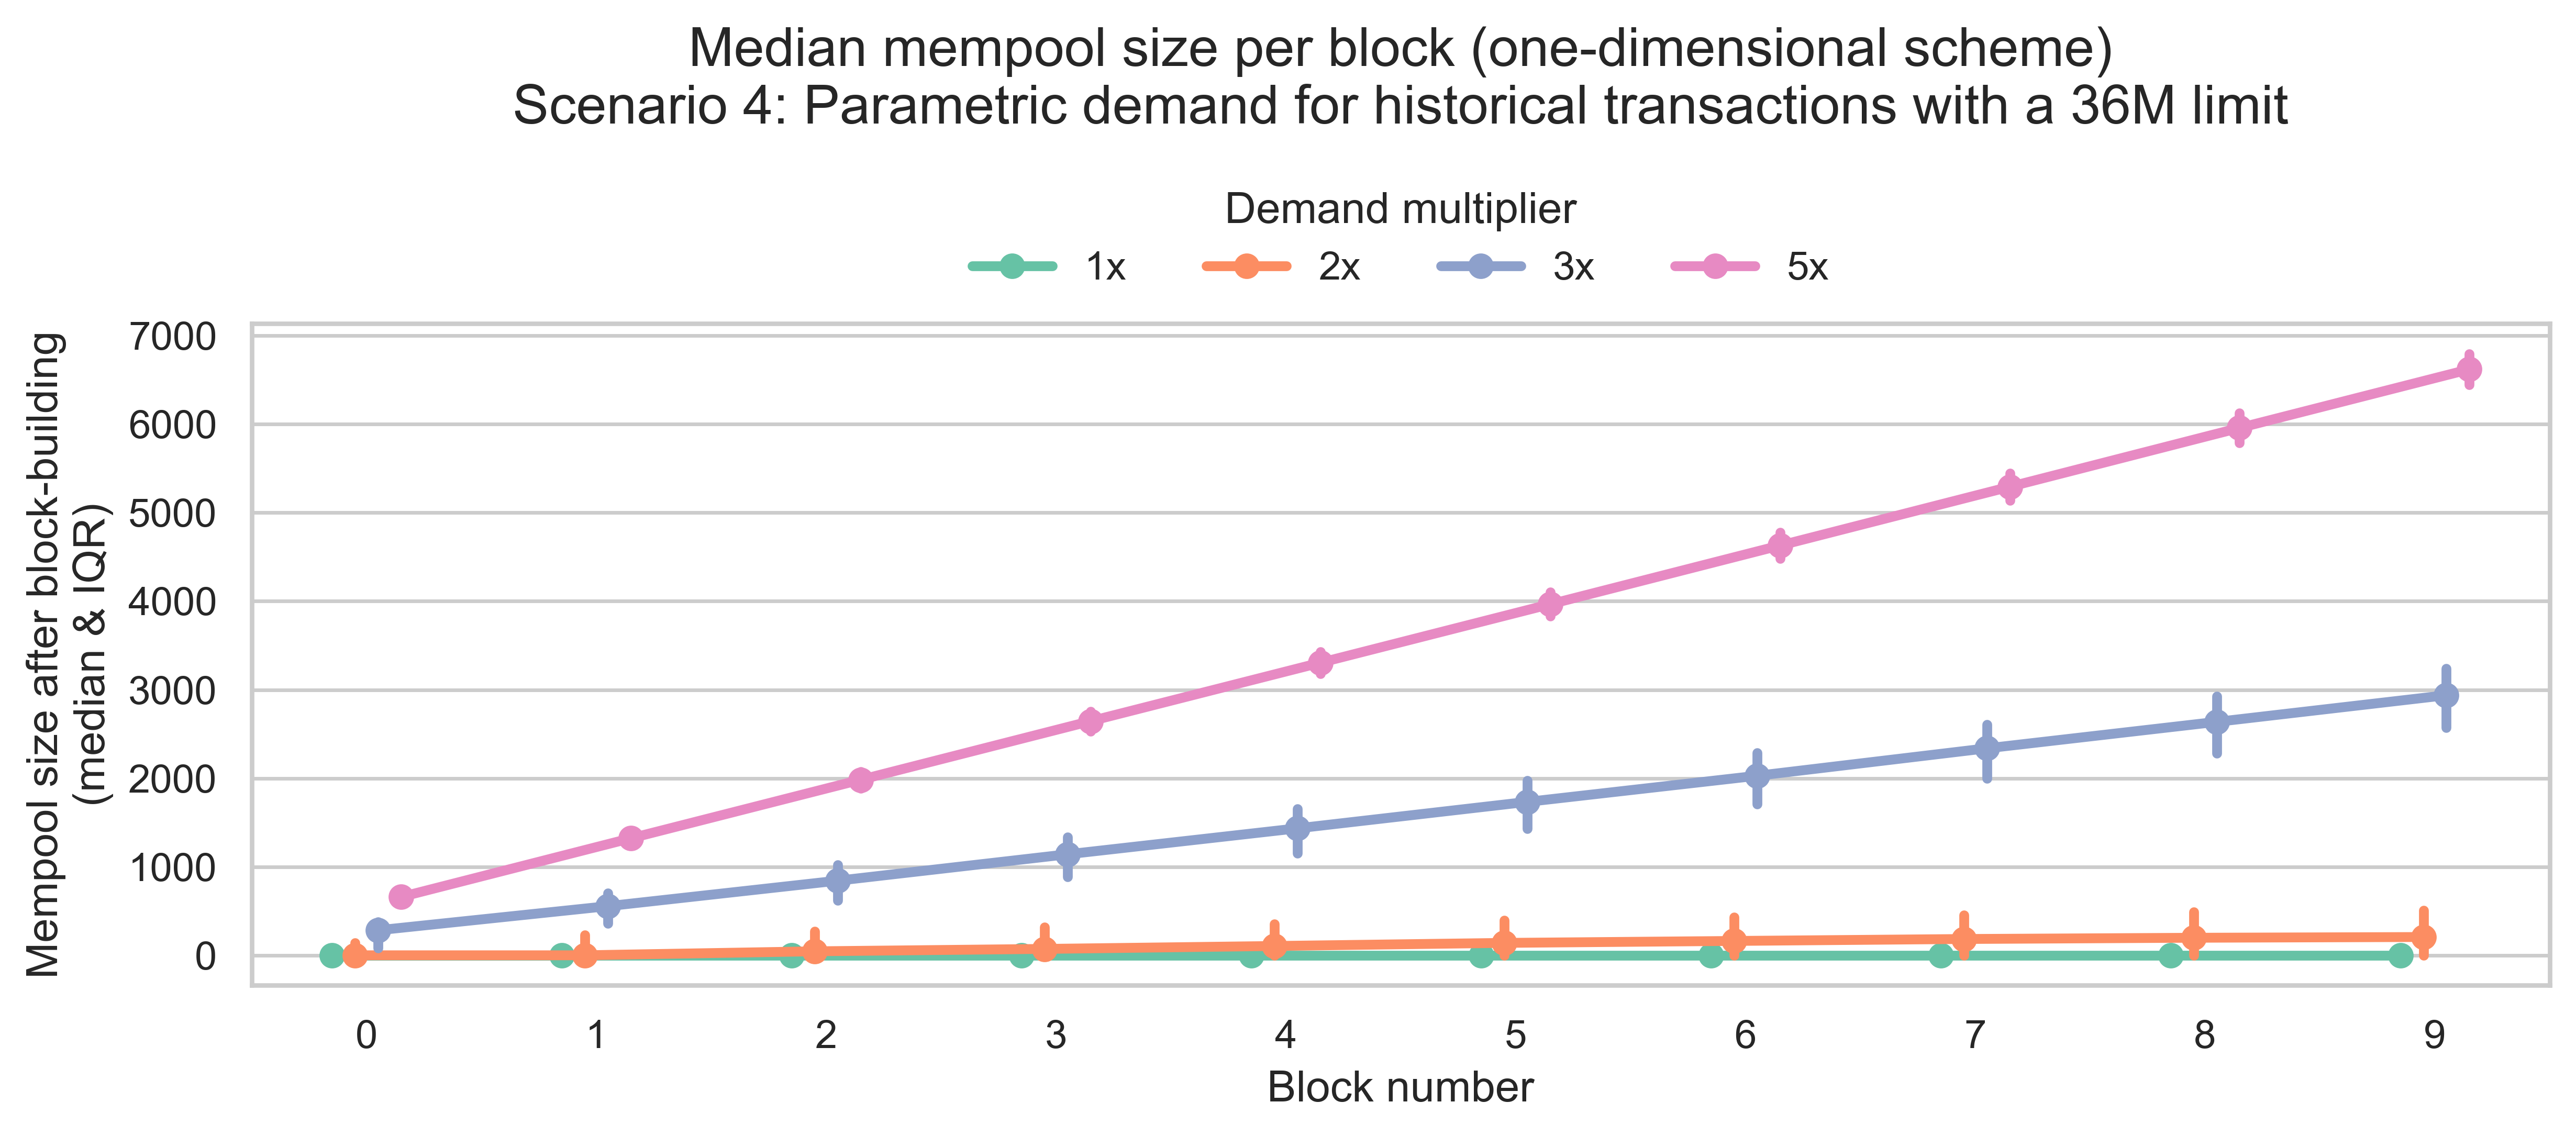

In [18]:
plt.figure(figsize=(10, 4.5))
ax = sns.pointplot(
    data=df_36[df_36["meter_scheme"]=="One-dimensional"],
    x="block",
    y="mempool_size",
    hue="Demand multiplier",
    errorbar=("pi", 50),
    estimator="median",
    markersize=5,
    dodge=0.3
)
plt.xlabel("Block number")
plt.ylabel("Mempool size after block-building\n(median & IQR)")
plt.title(
    f"Median mempool size per block (one-dimensional scheme)\n{scenario_title} with a 36M limit",
    pad=55,
)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, frameon=False,
)
plt.tight_layout()
plt.show()

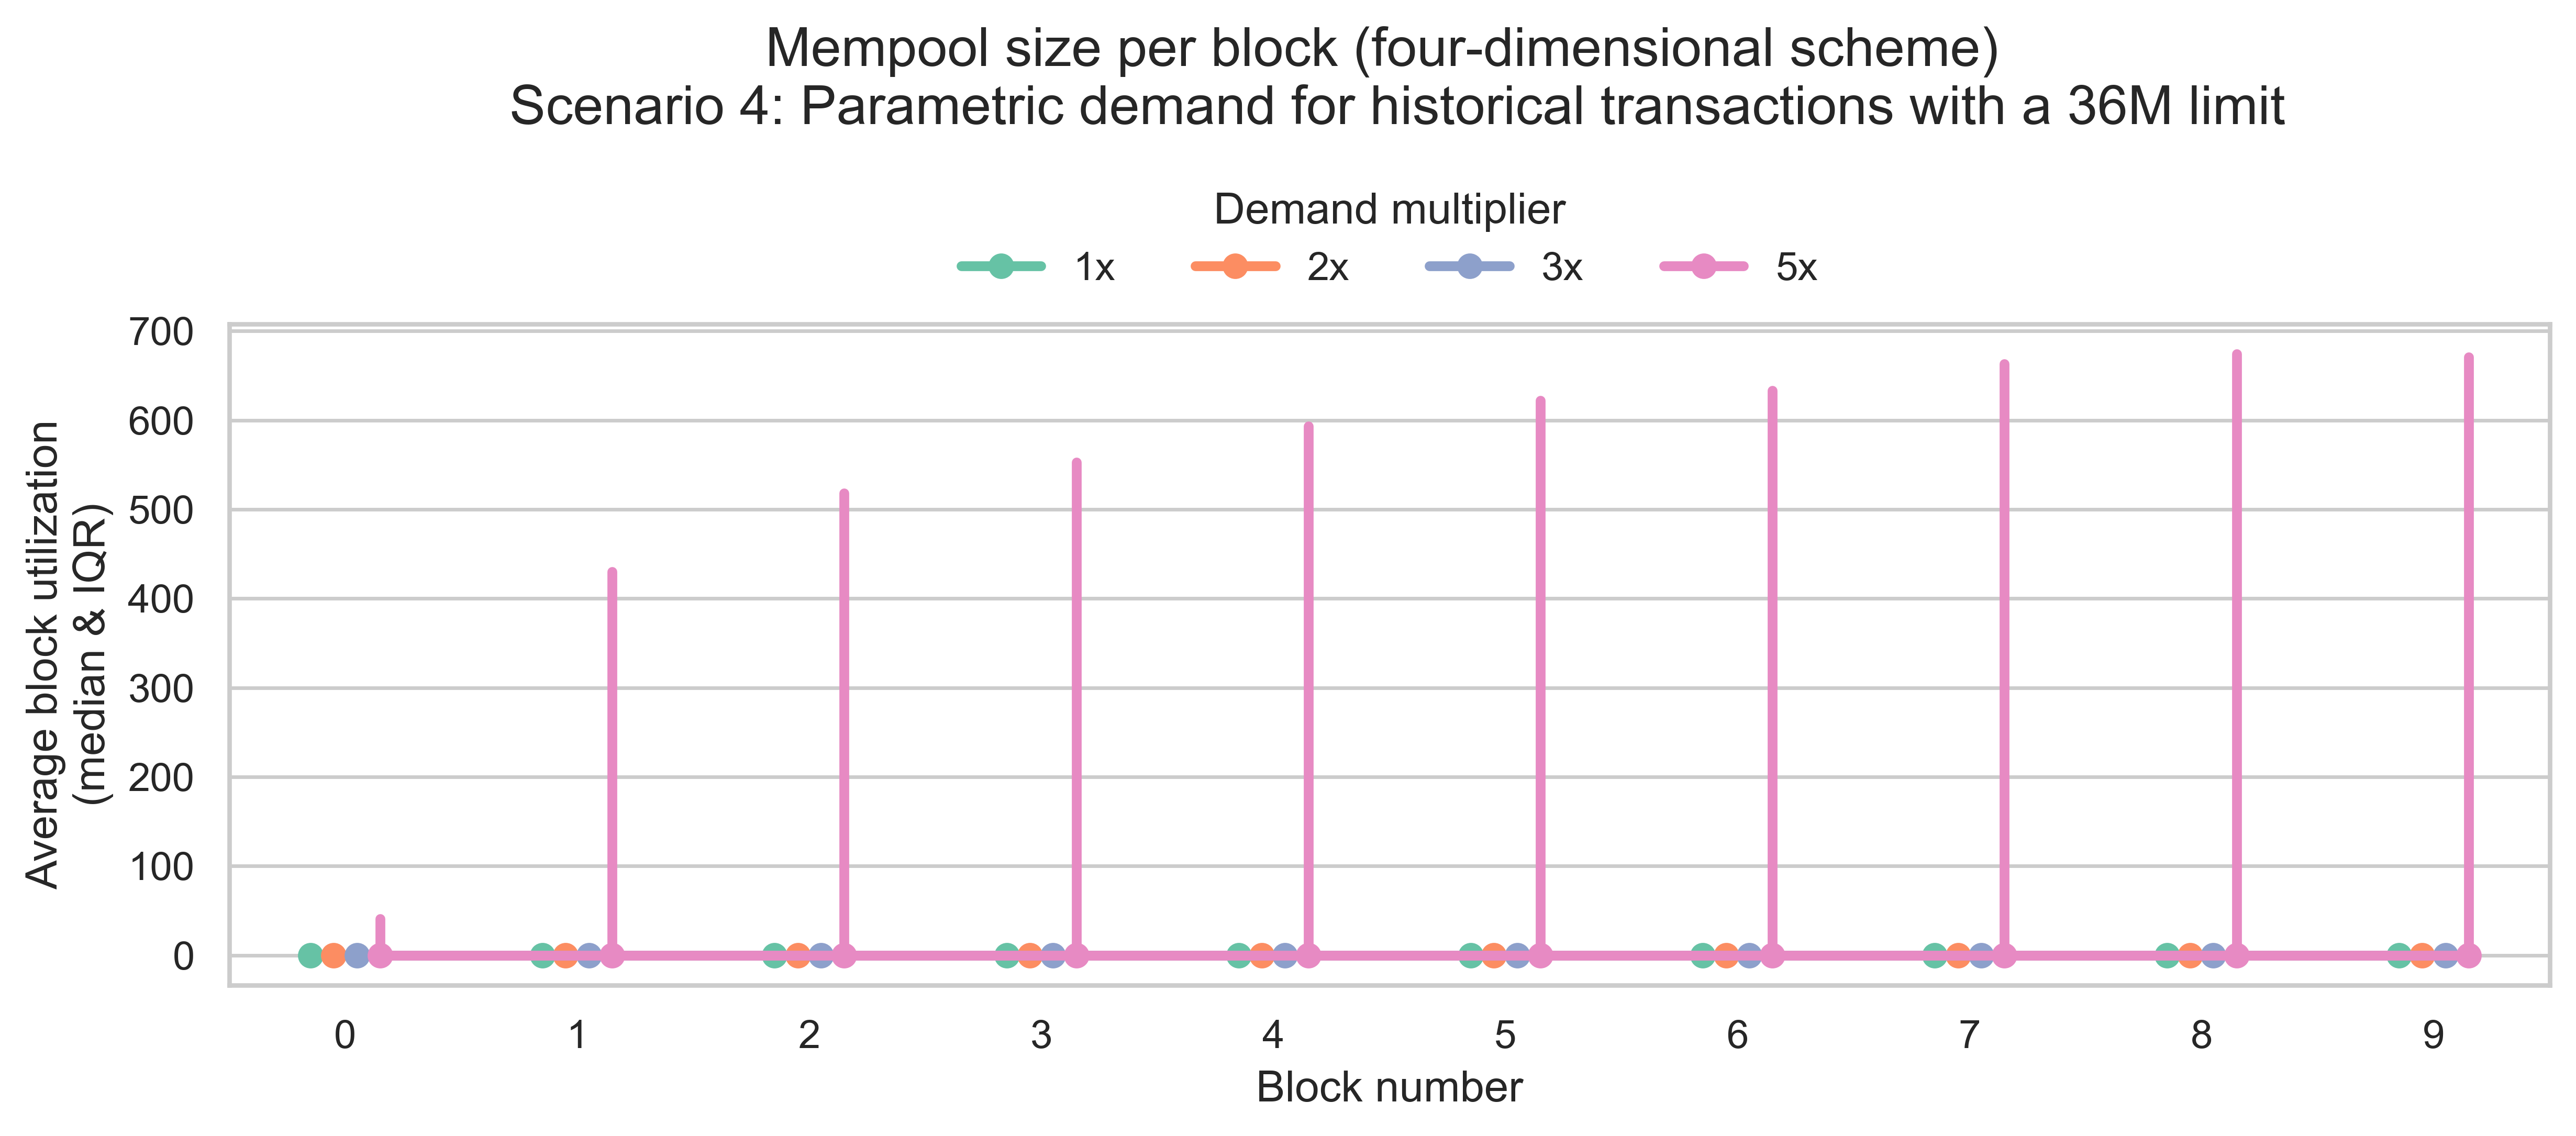

In [19]:
plt.figure(figsize=(10, 4.5))
ax = sns.pointplot(
    data=df_36[df_36["meter_scheme"]=="State vs. Compute vs. Access vs. Others"],
    x="block",
    y="mempool_size",
    hue="Demand multiplier",
    errorbar=("pi", 50),
    estimator="median",
    markersize=5,
    dodge=0.3
)
plt.xlabel("Block number")
plt.ylabel("Average block utilization\n(median & IQR)")
plt.title(
    f"Mempool size per block (four-dimensional scheme) \n {scenario_title} with a 36M limit",
    pad=55,
)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, frameon=False,
)
plt.tight_layout()
plt.show()